In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download sshikamaru/fruit-recognition
! unzip /content/fruit-recognition.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train/train/Pepper Green/Pepper Green_264.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_265.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_266.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_267.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_268.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_269.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_27.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_270.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_271.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_272.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_273.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_274.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_275.jpg  
  inflating: data/train/train/Pepper Green/Pepper Green_276.jpg  
  inflating: data/train/tr

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import matplotlib.image as mpimg
import random
from tensorflow.keras.utils import load_img, img_to_array
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:

train_data_path = "/content/data/train/train/"
test_data_path = "/content/data/test/test/"

# Creating a pathlib.Path object for the training data directory
train_data_dir = pathlib.Path(train_data_path)

data_class = np.array(sorted([classes.name for classes in train_data_dir.glob('*')]))
print(data_class)

['Apple Braeburn' 'Apple Granny Smith' 'Apricot' 'Avocado' 'Banana'
 'Blueberry' 'Cactus fruit' 'Cantaloupe' 'Cherry' 'Clementine' 'Corn'
 'Cucumber Ripe' 'Grape Blue' 'Kiwi' 'Lemon' 'Limes' 'Mango' 'Onion White'
 'Orange' 'Papaya' 'Passion Fruit' 'Peach' 'Pear' 'Pepper Green'
 'Pepper Red' 'Pineapple' 'Plum' 'Pomegranate' 'Potato Red' 'Raspberry'
 'Strawberry' 'Tomato' 'Watermelon']


In [4]:

train_data_dict = {'file_path' : [], 'file_name': [], 'class': []}

for dir_path, dirnames, filenames in os.walk(train_data_path):
    # For each file in the current directory
    for f in filenames:
        train_data_dict['file_path'].append(dir_path)
        train_data_dict['file_name'].append(f)
        train_data_dict['class'].append(f.split('_')[0])

# Create a dictionary to store test data
test_data_dict = {'file_path' : [], 'file_name': []}

# Traverse through each directory and file in the test data directory
for dirpath, dirnames, filenames in os.walk(test_data_path):
    # For each file in the current directory
    for f in filenames:
        # Append the path to the file to the dictionary
        test_data_dict['file_path'].append(dirpath)
        test_data_dict['file_name'].append(f)

In [5]:
# Create a pandas DataFrame from the train data dictionary
train_dataframe = pd.DataFrame(train_data_dict)

test_dataframe = pd.DataFrame(test_data_dict)

print('Training data images', train_dataframe.shape[0])
print('Testing data images', test_dataframe.shape[0])

Training data images 16854
Testing data images 5641


In [6]:
train_dataframe.head(15)

,file_path,file_name,class
0,/content/data/train/train/Watermelon,Watermelon_101.jpg,Watermelon
1,/content/data/train/train/Watermelon,Watermelon_155.jpg,Watermelon
2,/content/data/train/train/Watermelon,Watermelon_397.jpg,Watermelon
3,/content/data/train/train/Watermelon,Watermelon_446.jpg,Watermelon
4,/content/data/train/train/Watermelon,Watermelon_88.jpg,Watermelon
5,/content/data/train/train/Watermelon,Watermelon_83.jpg,Watermelon
6,/content/data/train/train/Watermelon,Watermelon_59.jpg,Watermelon
7,/content/data/train/train/Watermelon,Watermelon_120.jpg,Watermelon
8,/content/data/train/train/Watermelon,Watermelon_297.jpg,Watermelon
9,/content/data/train/train/Watermelon,Watermelon_62.jpg,Watermelon


In [7]:
test_dataframe.head(15)

,file_path,file_name
0,/content/data/test/test/,1050.jpg
1,/content/data/test/test/,0974.jpg
2,/content/data/test/test/,1999.jpg
3,/content/data/test/test/,4301.jpg
4,/content/data/test/test/,4037.jpg
5,/content/data/test/test/,2818.jpg
6,/content/data/test/test/,0570.jpg
7,/content/data/test/test/,4265.jpg
8,/content/data/test/test/,4025.jpg
9,/content/data/test/test/,4458.jpg


In [8]:
print('Class count in Training data')
train_dataframe.groupby('class')['class'].count().sort_values(ascending = False)

Class count in Training data


class
Grape Blue            984
Tomato                738
Pear                  696
Pepper Red            666
Apple Braeburn        492
Papaya                492
Lemon                 492
Peach                 492
Cherry                492
Cantaloupe            492
Pomegranate           492
Strawberry            492
Apricot               492
Apple Granny Smith    492
Pineapple             490
Raspberry             490
Passion Fruit         490
Mango                 490
Limes                 490
Clementine            490
Cactus fruit          490
Banana                490
Orange                479
Watermelon            475
Kiwi                  466
Blueberry             462
Corn                  450
Potato Red            450
Plum                  447
Pepper Green          444
Onion White           438
Avocado               427
Cucumber Ripe         392
Name: class, dtype: int64

In [9]:
# Create empty lists to store images and their corresponding labels
image_array = []
labels_array = []

for index, single_image in train_dataframe.iterrows():

    current_img = img_to_array(load_img(os.path.join(single_image['file_path'], single_image['file_name'])))

    image_array.append(current_img)
    labels_array.append(single_image['class'])
test_images = []

for _, row in test_dataframe.iterrows():
    img = load_img(os.path.join(row['file_path'], row['file_name']))
    img_array = img_to_array(img)
    test_images.append(img_array)


In [10]:

image_array = np.array(image_array)
labels_array = np.array(labels_array)
test_images = np.array(test_images)

print('Single Image Shape:- ', image_array[0].shape)

Single Image Shape:-  (100, 100, 3)


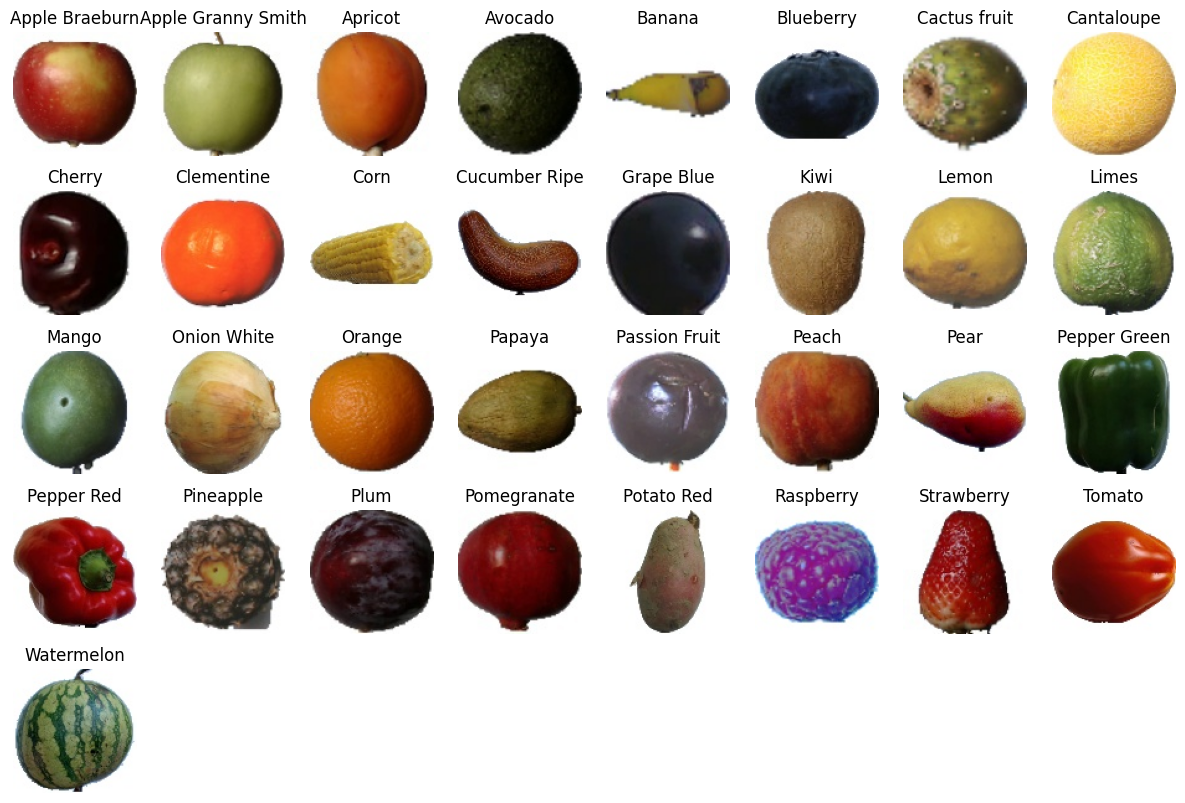

In [11]:
plt.figure(figsize = (15,10))

for i in range(len(data_class)):

    plt.subplot(5, 8, i+1)
    if train_data_path  not in data_class[i]:
      class_dir = train_data_path + data_class[i]
    else:
      class_dir = data_class[i]


    random_image_path = random.sample(os.listdir(class_dir), 1)[0]

    current_img = mpimg.imread(class_dir + "/" + random_image_path)

    plt.imshow(current_img)
    plt.title(data_class[i])
    plt.axis("off")

# Show the plot
plt.show()

In [12]:
# Create an empty dictionary to store the fruit class indices
fruit_class_indices = {}

for i in range(len(data_class)):
    fruit_class_indices[data_class[i]] = i

label_indices = []
for fruit_label in labels_array:
    label_indices.append(fruit_class_indices[fruit_label])

label_categorical = tf.keras.utils.to_categorical(label_indices, num_classes=len(data_class), dtype='uint8')

In [13]:
model = tf.keras.Sequential()

model.add(tf.keras.applications.mobilenet.MobileNet(weights='imagenet',
                                                    include_top=False,
                                                    input_shape=(100, 100, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(33, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 3, 3, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 256)               2359552   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 33)                8481      
                                                                 
Total params: 5596897 (21.35 MB)
Trainable params: 557500

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(x = image_array, y = label_categorical, epochs=10, steps_per_epoch = len(image_array)/ 32, batch_size = 32, )

Epoch 1/10
526/526 [==============================] - 41s 37ms/step - loss: 0.3139 - accuracy: 0.9274
Epoch 2/10
526/526 [==============================] - 18s 33ms/step - loss: 0.0102 - accuracy: 0.9969
Epoch 3/10
526/526 [==============================] - 17s 32ms/step - loss: 0.0059 - accuracy: 0.9985
Epoch 4/10
526/526 [==============================] - 17s 31ms/step - loss: 0.0095 - accuracy: 0.9979
Epoch 5/10
526/526 [==============================] - 17s 32ms/step - loss: 0.0098 - accuracy: 0.9967
Epoch 6/10
526/526 [==============================] - 17s 32ms/step - loss: 0.0164 - accuracy: 0.9956
Epoch 7/10
526/526 [==============================] - 17s 32ms/step - loss: 0.0099 - accuracy: 0.9974
Epoch 8/10
526/526 [==============================] - 17s 32ms/step - loss: 0.0080 - accuracy: 0.9980
Epoch 9/10
526/526 [==============================] - 17s 32ms/step - loss: 0.0104 - accuracy: 0.9979
Epoch 10/10
526/526 [==============================] - 17s 32ms/step - loss: 0.017

In [15]:
print(history.history)

{'loss': [0.3139149844646454, 0.01021438930183649, 0.005916510708630085, 0.009466477669775486, 0.009817690588533878, 0.016432903707027435, 0.009884919971227646, 0.008029974065721035, 0.010394944809377193, 0.017850490286946297], 'accuracy': [0.9273762702941895, 0.9969146847724915, 0.9984573125839233, 0.9978640079498291, 0.9967367053031921, 0.9955500364303589, 0.9974486827850342, 0.9980419874191284, 0.9978640079498291, 0.9959653615951538]}


In [16]:
random_index = np.random.choice(range(len(image_array)), size = 1000)
train_random_image = image_array[random_index]
print('Random sample images', len(train_random_image))
train_random_label = np.array(label_indices)[random_index]

Random sample images 1000


In [17]:
train_predicted_output = model.predict(train_random_image)
final_predicted_class = []
for single_output in train_predicted_output:
  final_predicted_class.append(np.argmax(single_output))

32/32 [==============================] - 1s 18ms/step


In [18]:
reverse_encoding = {v: k for k, v in fruit_class_indices.items()}

In [19]:
predicted_class = [reverse_encoding[v] for v in final_predicted_class]
original_class = [reverse_encoding[v] for v in train_random_label]

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


accuracy = accuracy_score(original_class, predicted_class)
precision = precision_score(original_class, predicted_class, average='macro')
recall = recall_score(original_class, original_class, average='macro')
f1 = f1_score(original_class, predicted_class, average='macro')

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1 score", f1)


Accuracy 1.0
Precision 1.0
Recall 1.0
F1 score 1.0


In [21]:
cf_matrix = confusion_matrix(original_class, predicted_class, labels = list(fruit_class_indices.keys()))

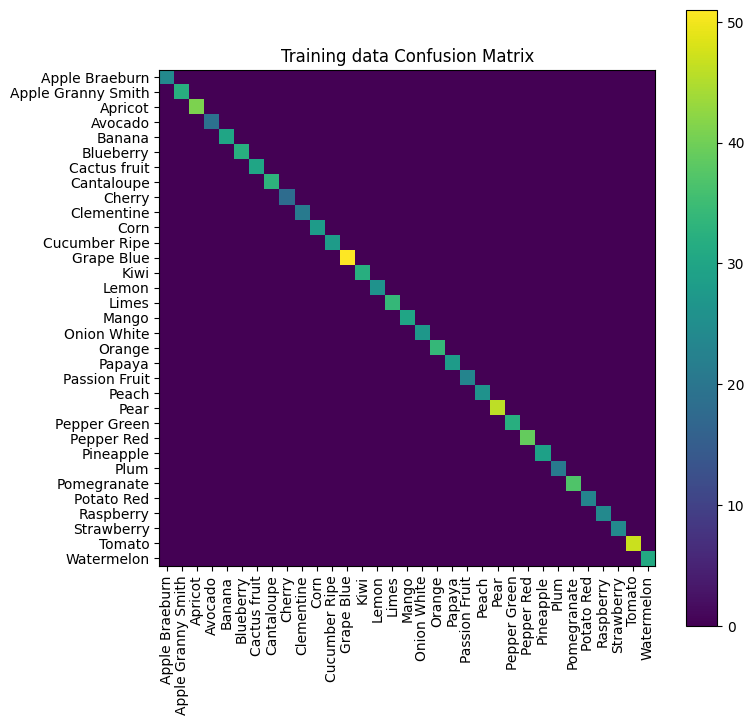

In [22]:
plt.figure(figsize=(8, 8))
plt.imshow(cf_matrix)
plt.title("Training data Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(data_class))
plt.xticks(tick_marks, data_class, rotation=90)
plt.yticks(tick_marks, data_class)
plt.show()

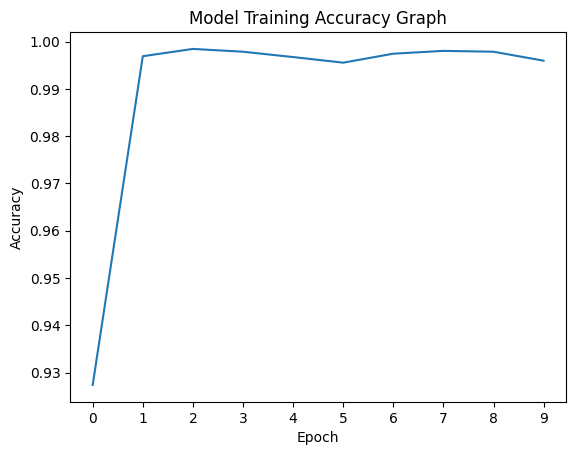

In [23]:
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy Graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(10))
plt.show()

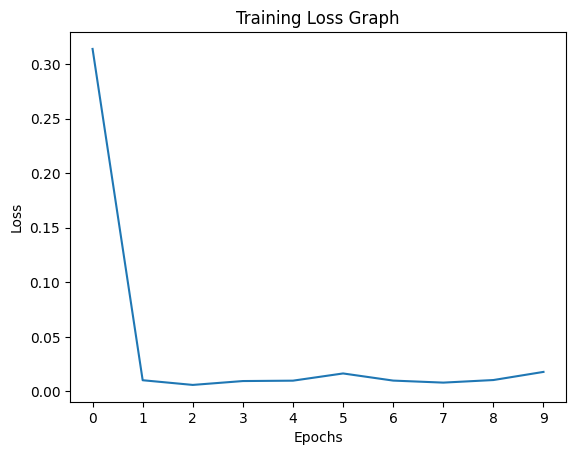

In [24]:
plt.plot(history.history['loss'])
plt.title('Training Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(10))
plt.show()